In [1]:
import gym
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import torch

#import sys
#sys.path.append('../')
from agent import DQNAgent
from model import ConvQNet

In [2]:
env = gym.make('Breakout-v0')
print(env.observation_space)
print(env.action_space.n)
print(env.unwrapped.get_action_meanings())

Box(210, 160, 3)
4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [3]:
a_dim = 4

# 1. Preprocess image

* 4 consecutive frames are stacked together to capture the speed, direction  and other time-dependent info
* crop above and bottom of the original image and downsampling to 80 * 80 image
* convert RGB representation to gray-scale

In [4]:
def preprocess_frames(frame_list):
    x = np.asarray(frame_list) # stack frames
    x = x[:,34:-16:2,::2,:] # crop and downsampling
    x = np.mean(x, axis = -1)/255.  # convert to grey scale
    return x

In [5]:
env.reset()
frame_list = []
for _ in range(4):
    action = random.choice(np.arange(a_dim))
    frame, reward, done, _ = env.step(action)   
    frame_list.append(frame)

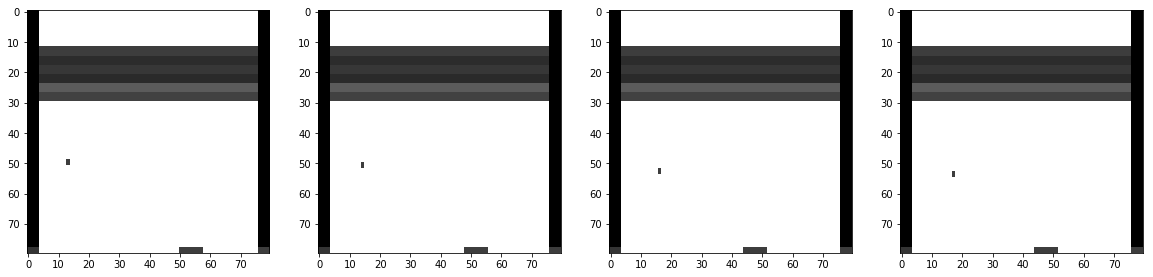

In [6]:
frame = preprocess_frames(frame_list)


fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(141)
action = env.action_space.sample() 
state, reward, done, _ = env.step(action)
frame = preprocess_frames([state])
ax.imshow(frame[0], cmap='Greys')

ax = fig.add_subplot(142)
action = env.action_space.sample() 
state, reward, done, _ = env.step(action)
frame = preprocess_frames([state])
ax.imshow(frame[0], cmap='Greys')

ax = fig.add_subplot(143)
action = env.action_space.sample() 
state, reward, done, _ = env.step(action)
frame = preprocess_frames([state])
ax.imshow(frame[0], cmap='Greys')

ax = fig.add_subplot(144)
action = env.action_space.sample() 
state, reward, done, _ = env.step(action)
frame = preprocess_frames([state])
ax.imshow(frame[0], cmap='Greys')

plt.show()

# 2. Train agent

In [8]:
c_dim = 2
agent = DQNAgent(ConvQNet, c_dim, a_dim, lr = 1e-4, lr_step_size = 40, batch_size = 64)
print(agent.algorithm)
agent.target_net

ddqn


ConvQNet(
  (features): ConvBase(
    (conv1): Conv2d(2, 32, kernel_size=(8, 8), stride=(4, 4))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [9]:
# parameters for training
NUM_EPISODES = 100
PRINT_EVERY = 10
TMAX = 1000

eps_start = 1.0
eps_end = 0.01
eps_decay = 0.95

In [ ]:
score_list = []
score_window = deque(maxlen = 30)
best_score = 10.0

eps = eps_start
for e in range(1, NUM_EPISODES+1):
    score = 0
    fr1 = env.reset()
    fr2, _, _, _ = env.step(1)
    state = preprocess_frames([fr1, fr2])
    for t in range(TMAX):
        action = agent.get_action(state, eps)
        fr1, r1, done, _ = env.step(action)  
        if done:
            break
        fr2, r2, done, _ = env.step(0)
        next_state = preprocess_frames([fr1, fr2])
        score += (r1 + r2)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break

    eps = max(eps_end, eps_decay*eps) # decrease exploartion
    agent.scheduler.step()
                
    score_window.append(score)
    mean_score = np.mean(score_window)
    score_list.append([score, mean_score])
    
    print('\rEpisode {}\t score {:8.2f}'.format(e, score), end = "")
    if e % PRINT_EVERY == 0:
        print('\rEpisode {}\t score {:8.2f}'.format(e, score))
            
    if score >= best_score:
        print('\rEpisode {}\t score {:8.2f}\t saved!'.format(e, score))
        torch.save(agent.online_net.state_dict(), 'gpu_checkpoint.pth')
        best_score = score

Episode 10	 score     1.00
Episode 20	 score     1.00
Episode 30	 score     2.00
Episode 40	 score     1.00
Episode 50	 score     0.00
Episode 60	 score     0.00
Episode 64	 score     1.00

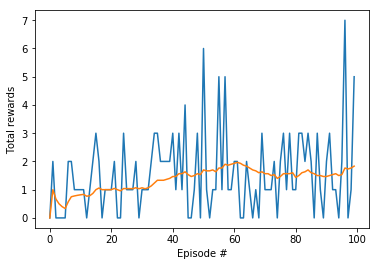

In [12]:
fig = plt.figure()
plt.plot(np.arange(len(score_list)), score_list)
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.savefig('plot_of_rewards.png')
plt.show()

In [108]:
agent.online_net.load_state_dict(torch.load('gpu_checkpoint.pth'))
torch.save(agent.online_net.cpu().state_dict(), 'Breakout-v0.pth')

# 3. Let agent play

In [11]:
# load checkpoint parameters
agent.online_net.load_state_dict(torch.load('Breakout.pth.pth'))
agent.online_net.eval()

NUM_FRAMES = 4
NUM_EPISODES = 3
for e in range(1, NUM_EPISODES+1):
    # initialize 
    env.reset()
    sum_rewards = 0
    frame_list = deque(maxlen = NUM_FRAMES)
    for _ in range(NUM_FRAMES):
        action = env.action_space.sample()
        frame, reward, done, _ = env.step(action)
        sum_rewards += reward
        frame_list.append(frame)
        
    state = preprocess_frames(frame_list)
    while True:
        action = agent.act(state, eps)
        reward, next_state, done = collect_tuple(env, action, k = NUM_FRAMES)
        state = next_state
        sum_rewards += reward
        print('\rEpisode {}...sum of rewards {}'.format(e, sum_rewards), end="")
        if done:
            break
        
    print('\rEpisode {}...sum of rewards {}'.format(e, sum_rewards))

Episode 1...sum of rewards 91.0
Episode 2...sum of rewards 55.0
Episode 3...sum of rewards 43.0


In [13]:
# save a cpu copy
torch.save(agent.online_net.cpu().state_dict(), 'cpu_checkpoint.pth')

In [ ]:
# close the environment
env.close()